# Разработка линейной модели

#### 1. Загрузка данных и их перобработка

Для начала так же загрузим данные (теперь уже будет использоваться измененный набор данных без корелирующих признаков и с заполненными значениями) и предобработаем их.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

In [2]:
df = pd.read_csv('table_linear.csv')

drop_list = ['Регион','Качество жизни']
target = 'Качество жизни'

In [3]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(drop_list,axis = 1),
                                                 df[target],
                                                 random_state = 22,
                                                 test_size = 0.25)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Также добавим функции для оценки качества.

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

measured_metrics = pd.DataFrame({'Type_metrics':["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index('Type_metrics', inplace=True )

def print_metrics(y_test,y_pred,type_metric):
    metric_error = [
        metrics.mean_absolute_error(y_test, y_pred),
        np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        metrics.r2_score(y_test, y_pred),
        mean_absolute_percentage_error(y_test, y_pred)
    ]
    measured_metrics[type_metric] = metric_error
    print(measured_metrics)

#### 2. Построение моделей

Теперь потроим модели линеной регресси сначало без нормализации.

In [5]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_scaled,y_train)
y_predict = lin_reg.predict(x_test_scaled)
print_metrics(y_test,y_predict,'LinearRegression')

              LinearRegression
Type_metrics                  
MAE                   3.908041
RMSE                  4.532582
R2                    0.864997
MAPE                  9.533812


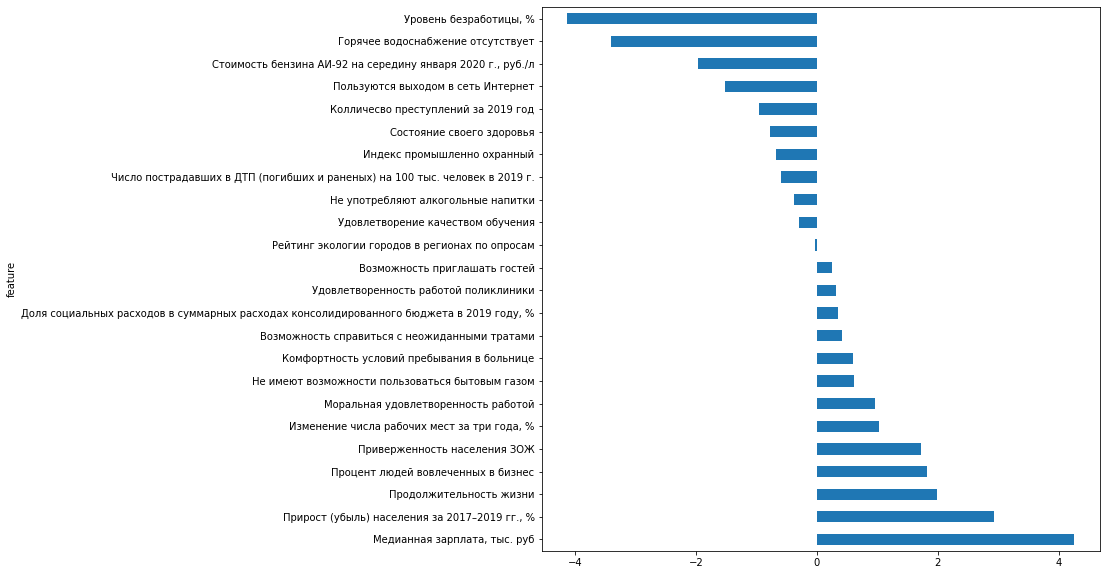

In [6]:
feature = pd.DataFrame({'feature':df.drop(drop_list,axis = 1).columns,'importence':lin_reg.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,10))

Теперь попробуем нормализацию Гребнева.

In [7]:
ridge = RidgeCV(alphas = [1.2])
ridge.fit(x_train_scaled,y_train)
y_pred_ridge = ridge.predict(x_test_scaled)
print_metrics(y_test,y_pred_ridge,'Ridge')

              LinearRegression     Ridge
Type_metrics                            
MAE                   3.908041  3.928545
RMSE                  4.532582  4.558473
R2                    0.864997  0.863450
MAPE                  9.533812  9.737732


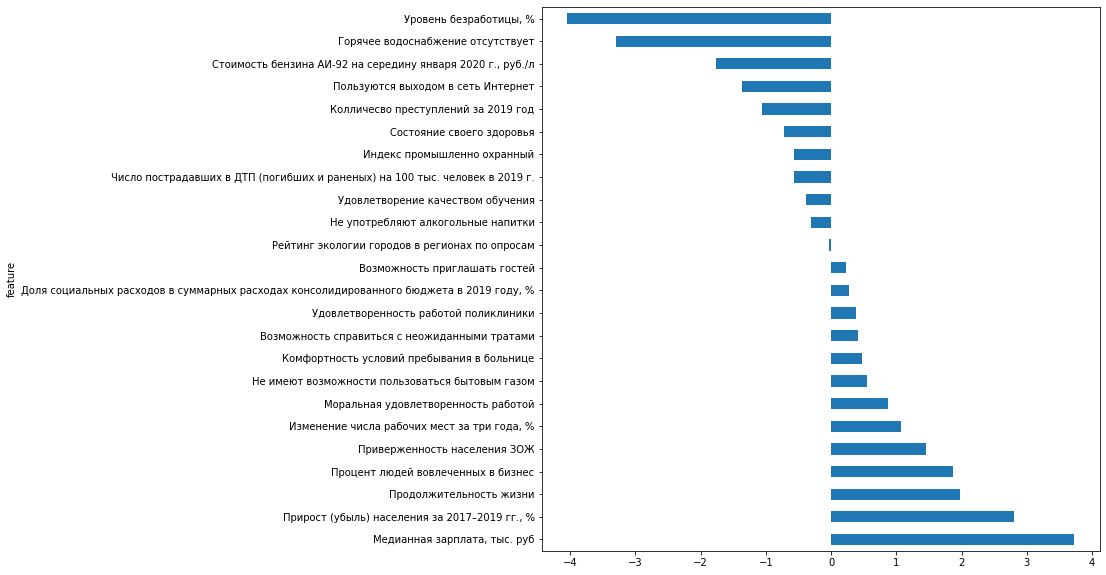

In [8]:
feature = pd.DataFrame({'feature':df.drop(drop_list,axis = 1).columns,'importence':ridge.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,10))

Теперь лассо нормализацию

In [9]:
lasso = LassoCV()
lasso.fit(x_train_scaled,y_train)
y_pred_lasso = lasso.predict(x_test_scaled)
print_metrics(y_test,y_pred_lasso,'Lasso')

              LinearRegression     Ridge     Lasso
Type_metrics                                      
MAE                   3.908041  3.928545  3.561481
RMSE                  4.532582  4.558473  4.978129
R2                    0.864997  0.863450  0.837151
MAPE                  9.533812  9.737732  8.707800


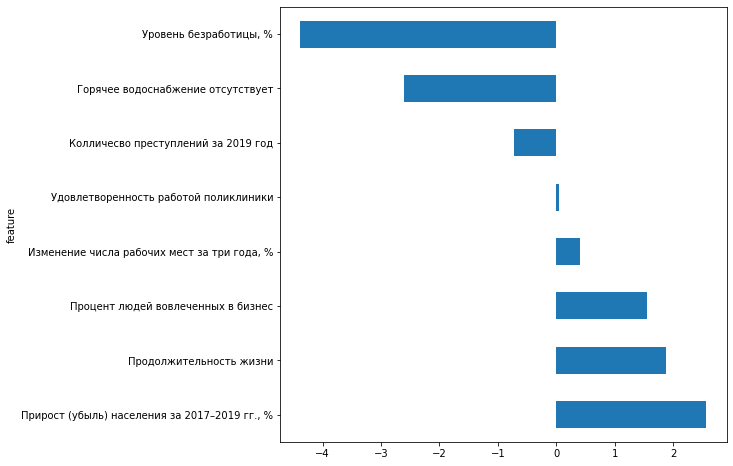

In [10]:
feature = pd.DataFrame({'feature':df.drop(drop_list,axis = 1).columns,'importence':lasso.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)

table = feature['importence'].apply(lambda x: x if x!=0 else None)
table.dropna(axis=0,inplace=True)
report_table = pd.DataFrame(table.values,table.index)
report_table.plot(kind = 'barh', figsize = (8,8),legend = False)

#### 3. Анализ значимых признаков

В целом более точной моделью является лассо регрессия, однако она испольузет минимальный набор призаков что может быть не очень хорошо при большой выборке. Однако обычная регрессия и нормализация Гребнева тоже могут быть использованы так как включают наибольшее число признаков, что качается их различие в точности, то это можно списать на небольшую выборку. <p>
    Теперь перейдем непосредственно к признакам оказавшим наибольшее влияние на модель. Такие признаки как: 
1. Прирост населения
2. Продолжительность жизни
3. Процент людей имеющих свое дело 
4. Изменение рабочих мест
5. Приверженность ЗОЖ
6. Медианная зарплата

<p>Однозначно имеют положительное влияние на уровень счастья граждан (опираясь на ретинг уровня жизни), а такие прзнаки как:
    
1. Уровень безработицы
2. Отсутствие горячего водоснабжения
3. Колличество преступлений
4. Стоимость бензина
5. Количество людей постоянно пользующихся интернетом

Теперь отсечем признаки вносившие наименьший вклад  в определение уровня счастья и составим регресси с новым набором данных, признаки подлежащие устранению:
1. Рейтинг экологии городов
2. Доля социальных расходов в суммарных расходах  бюджета
3. Возможность приглашать гостей
4. Удовлетворение качеством обучения
5. Удовлетворенность работой поликлиники
6. Процент населения не употребляющих алкогольные напитки
7. Возжмность семей справиться с неожиданными тратами
8. Оценка состояние своего здоровья гражданами
9. Процент домохозяйств не имеющих возможности пользоваться бытовым газом

In [11]:
df_new = df.copy(deep = True).drop(['Рейтинг экологии городов в регионах по опросам',
                                    'Доля социальных расходов в суммарных расходах консолидированного бюджета в 2019 году, %',
                                    'Возможность приглашать гостей','Удовлетворение качеством обучения',
                                    'Удовлетворенность работой поликлиники',
                                    'Не употребляют алкогольные напитки','Возможность справиться с неожиданными тратами',
                                    'Состояние своего здоровья','Не имеют возможности пользоваться бытовым газом'], axis = 1)

measured_metrics = pd.DataFrame({'Type_metrics':["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index('Type_metrics', inplace=True )

In [12]:
x_train_new,x_test_new,y_train_new,y_test_new = train_test_split(df_new.drop(drop_list,axis = 1),
                                                                 df_new[target],
                                                                 random_state = 22,
                                                                 test_size = 0.25)

scaler_new = StandardScaler()
scaler_new.fit(x_train_new)
x_train_scaled_new = scaler_new.transform(x_train_new)
x_test_scaled_new = scaler_new.transform(x_test_new)

In [13]:
ridge_new = RidgeCV(alphas = [1.2])
ridge_new.fit(x_train_scaled_new,y_train_new)
y_pred_ridge_new = ridge_new.predict(x_test_scaled_new)
print_metrics(y_test_new,y_pred_ridge_new,'Ridge')

                 Ridge
Type_metrics          
MAE           3.549440
RMSE          4.518665
R2            0.865824
MAPE          8.641239


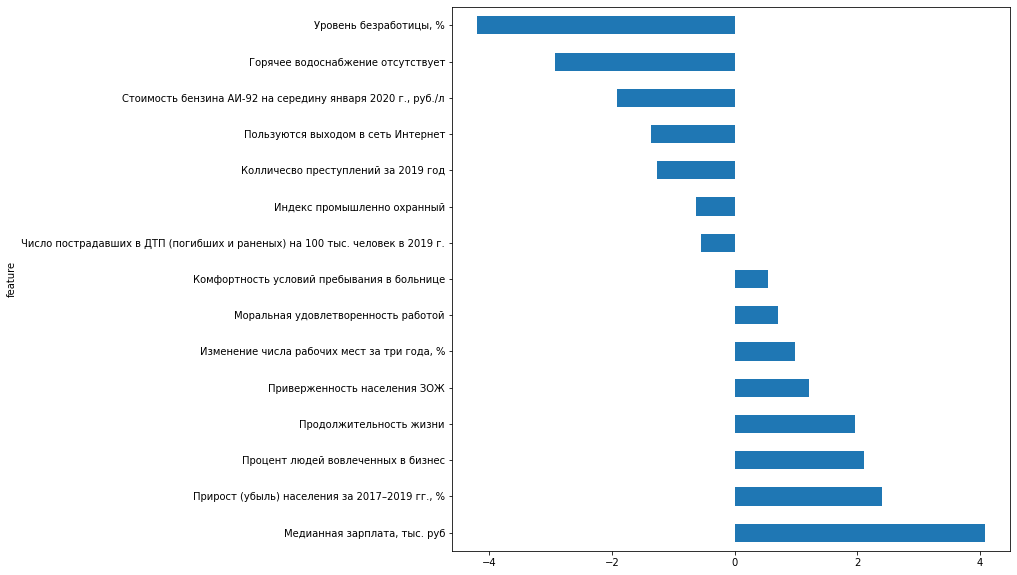

In [14]:
feature = pd.DataFrame({'feature':df_new.drop(drop_list,axis = 1).columns,'importence':ridge_new.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,10))

In [15]:
lasso_new = LassoCV()
lasso_new.fit(x_train_scaled_new,y_train_new)
y_pred_lasso_new = lasso_new.predict(x_test_scaled_new)
print_metrics(y_test_new,y_pred_lasso_new,'Lasso')

                 Ridge     Lasso
Type_metrics                    
MAE           3.549440  3.608313
RMSE          4.518665  4.583238
R2            0.865824  0.861962
MAPE          8.641239  8.652594


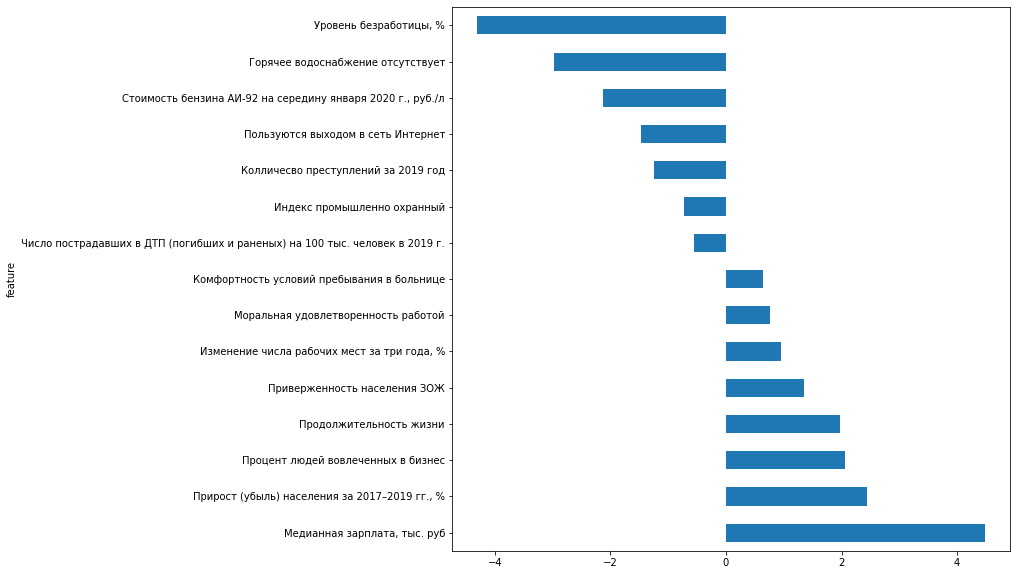

In [16]:
feature = pd.DataFrame({'feature':df_new.drop(drop_list,axis = 1).columns,'importence':lasso_new.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,10))

#### 4. Заключение
Как мы видим при исключении ряда признаков мы получили чуть улучшенную версию Ridge регрессию. Lasso регрессия почти полностью теперь совпадает с Ridge. В качестве финальной версии модели принимаем RidgeRegressionСV с коэфициентом альфа 1.2 и обозначенным набором признаков.